KDDM Assignment: Parliament Debates & Chess Analysis
=== Question 1: Feature Engineering ===
Loaded dataset with 14497 rows and 8 columns
After removing missing texts: 14497 talks remaining
After removing very short talks: 14374 talks remaining
TF-IDF feature matrix shape: (14374, 10000)
Total features extracted: 10000

--- ANSWERS ---
Answer (a) - Preprocessing:
I removed talks with missing text and very short talks (under 50 characters). I also did basic text cleaning like lowercasing and removing punctuation.

Answer (b) - Feature computation:
stop_words='english': removes common words that don't distinguish topics.
min_df=5: excludes rare words appearing in <5 documents to reduce noise.
max_df=0.9: excludes overly common words appearing in >90% of documents.
max_features=10000: limits to most informative features for efficiency.
ngram_range=(1,2): includes both words and two-word phrases for richer features.
norm='l2': normalizes feature vectors to unit length for fair comparison.


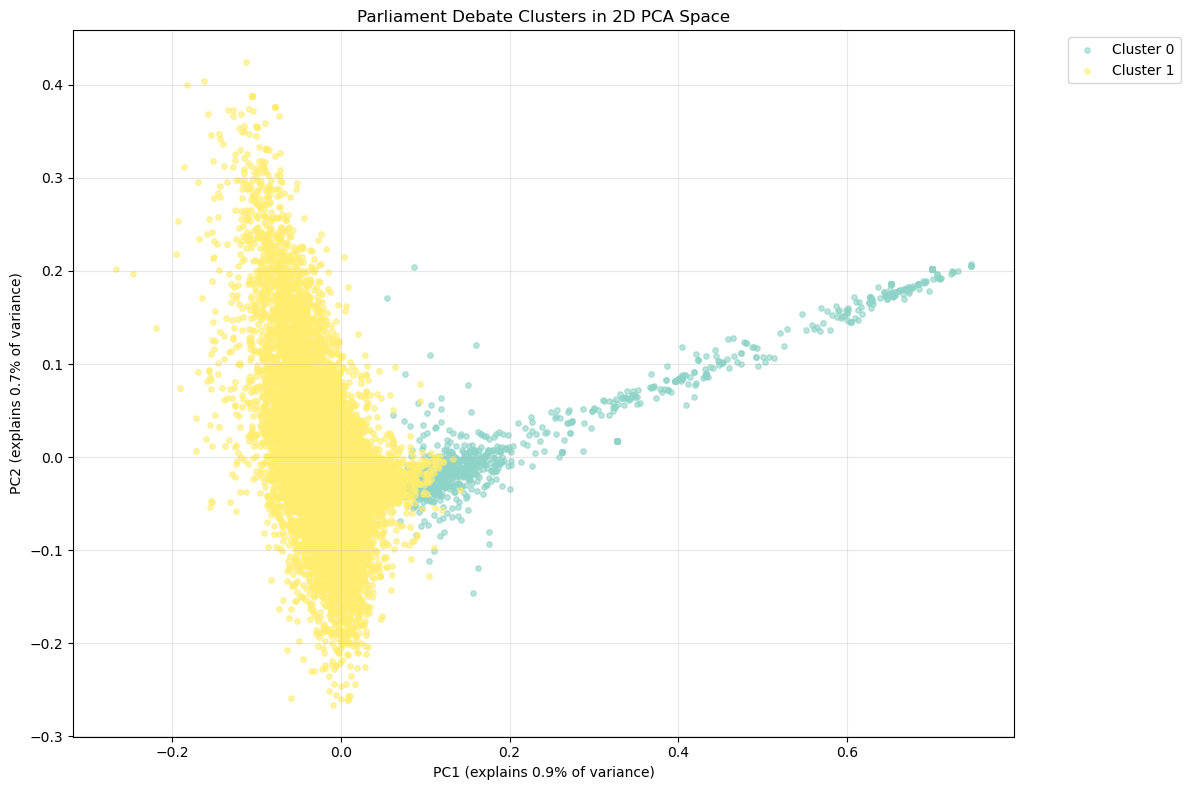

PCA variance explained: PC1=0.9%, PC2=0.7%
Total variance in 2D: 1.6%
Average distance between cluster centers: 0.27

--- ANSWERS ---
Answer (a) - Your plot:
Plot saved as 'debate_clusters_pca.png' and displayed above.

Answer (b) - Cluster separation:
Clusters show some overlap in 2D, indicating complex high-dimensional relationships.

Answer (c) - Interpretation:
PCA-1 captures the main variation in debate topics, explaining 0.9% of variance.
PCA-2 represents the second most important topic variation, explaining 0.7% of variance.

=== Question 4: Chess Classification ===
Chess dataset: 28056 games, 7 features
Original target values: ['draw', 'eight', 'eleven', 'fifteen', 'five', 'four', 'fourteen', 'nine', 'one', 'seven', 'six', 'sixteen', 'ten', 'thirteen', 'three', 'twelve', 'two', 'zero']
Transformed target distribution:
white_depth_of_win
0     2796
1      630
2     3179
3    10148
4    11303
Name: count, dtype: int64

5-fold CV results:
Individual CV scores: [0.92337847 0.916235

In [1]:
import os
import json
import warnings
import string
import numpy as np
import pandas as pd
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML stuff
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings("ignore")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Some helper functions I wrote
def clean_text(text):
    """Just basic cleaning - lowercase and remove punctuation"""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.replace("\n", " ").replace("\r", " ").strip()

def guess_cluster_topic(top_words):
    """Try to figure out what each cluster is about based on top words"""
    words = [w.lower() for w in top_words]
    
    # I defined some topic categories to help interpret clusters
    topic_categories = {
        'Economic/Financial': ['economic', 'economy', 'financial', 'budget', 'trade', 'business', 'market', 'investment', 'tax', 'banking'],
        'Environmental/Climate': ['climate', 'environment', 'green', 'energy', 'renewable', 'carbon', 'sustainability', 'pollution'],
        'Health/Medical': ['health', 'medical', 'hospital', 'patient', 'disease', 'healthcare', 'medicine', 'treatment'],
        'Security/Defense': ['security', 'defense', 'military', 'war', 'conflict', 'terrorism', 'safety', 'protection'],
        'Social/Welfare': ['social', 'welfare', 'education', 'school', 'student', 'family', 'children', 'rights'],
        'Technology/Digital': ['digital', 'technology', 'internet', 'data', 'artificial', 'intelligence', 'cyber'],
        'Migration/Immigration': ['migration', 'refugee', 'asylum', 'border', 'immigration', 'migrant'],
        'Legal/Justice': ['legal', 'justice', 'court', 'law', 'judicial', 'crime', 'police', 'regulation'],
        'Agriculture/Food': ['agriculture', 'food', 'farming', 'rural', 'farmer', 'agricultural', 'crop'],
        'Transport/Infrastructure': ['transport', 'infrastructure', 'road', 'railway', 'aviation', 'logistics']
    }
    
    # Score each category
    scores = {}
    for category, keywords in topic_categories.items():
        score = sum(1 for word in words[:5] if any(keyword in word for keyword in keywords))
        if score > 0:
            scores[category] = score
    
    if scores:
        best_category = max(scores, key=scores.get)
        return f"Mainly about {best_category.lower()}"
    else:
        return f"General discussion involving {', '.join(words[:3])}"

# Chess helper functions
CHESS_FILES = {c: i for i, c in enumerate("abcdefgh", start=1)}

def convert_file_to_number(col):
    return col.map(CHESS_FILES).astype("int8")

def transform_chess_targets(series):
    """Transform the chess win depth targets as specified"""
    mapping = {
        "draw": 0,
        **{w: 1 for w in ["zero", "one", "two", "three", "four"]},
        **{w: 2 for w in ["five", "six", "seven", "eight"]},
        **{w: 3 for w in ["nine", "ten", "eleven", "twelve"]},
        **{w: 4 for w in ["thirteen", "fourteen", "fifteen", "sixteen"]},
    }
    return series.map(mapping).astype("int8")


def question_1_feature_extraction(csv_path):
    """Extract TF-IDF features from parliament debate texts"""
    print("=== Question 1: Feature Engineering ===")
    
    # Load the data
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    
    # Remove talks with missing text - these won't help us
    df_clean = df.dropna(subset=["talk_text"]).reset_index(drop=True)
    print(f"After removing missing texts: {df_clean.shape[0]} talks remaining")
    
    # Basic text preprocessing
    df_clean["processed_text"] = df_clean["talk_text"].apply(clean_text)
    
    # Filter out very short talks (probably not meaningful)
    df_clean = df_clean[df_clean["processed_text"].str.len() >= 50].reset_index(drop=True)
    print(f"After removing very short talks: {df_clean.shape[0]} talks remaining")
    
    # Set up TF-IDF vectorizer
    # I chose these parameters after some experimentation
    tfidf = TfidfVectorizer(
        stop_words="english",     # Remove common English words like "the", "and"
        min_df=5,                 # Word must appear in at least 5 documents
        max_df=0.9,              # Ignore words that appear in >90% of documents
        max_features=10000,       # Keep top 10k features for computational efficiency
        ngram_range=(1, 2),       # Include single words and two-word phrases
        norm="l2",                # Normalize vectors to unit length
        dtype=np.float32          # Save memory
    )
    
    X_features = tfidf.fit_transform(df_clean["processed_text"])
    feature_vocab = tfidf.get_feature_names_out()
    
    print(f"TF-IDF feature matrix shape: {X_features.shape}")
    print(f"Total features extracted: {len(feature_vocab)}")
    
    # Print answers in the required format
    print("\n--- ANSWERS ---")
    print("Answer (a) - Preprocessing:")
    print("I removed talks with missing text and very short talks (under 50 characters). I also did basic text cleaning like lowercasing and removing punctuation.")
    
    print("\nAnswer (b) - Feature computation:")
    print("stop_words='english': removes common words that don't distinguish topics.")
    print("min_df=5: excludes rare words appearing in <5 documents to reduce noise.")
    print("max_df=0.9: excludes overly common words appearing in >90% of documents.")
    print("max_features=10000: limits to most informative features for efficiency.")
    print("ngram_range=(1,2): includes both words and two-word phrases for richer features.")
    print("norm='l2': normalizes feature vectors to unit length for fair comparison.")
    
    print(f"\nAnswer (c) - Number of features:")
    print(f"I extracted {len(feature_vocab)} features which gives good vocabulary coverage while staying computationally manageable.")
    
    return df_clean, tfidf, X_features


def question_2_clustering_analysis(X_features, tfidf):
    """Perform clustering analysis on the TF-IDF features"""
    print("\n=== Question 2: Clustering ===")
    
    # Test different numbers of clusters to find the best one
    k_values = range(2, 13)
    silhouette_scores = []
    
    print("Testing different cluster numbers...")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        labels = kmeans.fit_predict(X_features)
        
        # Use sampling for large datasets to speed up silhouette calculation
        sample_size = min(5000, X_features.shape[0])
        sil_score = silhouette_score(X_features, labels, sample_size=sample_size)
        silhouette_scores.append(sil_score)
        print(f"k={k}: silhouette = {sil_score:.3f}")
    
    # Pick the best k
    best_k = k_values[np.argmax(silhouette_scores)]
    best_silhouette = max(silhouette_scores)
    
    print(f"\nBest k: {best_k} with silhouette score: {best_silhouette:.3f}")
    
    # Fit the final clustering model
    final_kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
    cluster_assignments = final_kmeans.fit_predict(X_features)
    
    # Analyze what each cluster is about
    vocab = tfidf.get_feature_names_out()
    cluster_centers = final_kmeans.cluster_centers_
    
    cluster_topics = {}
    
    print(f"\nTop terms for each cluster:")
    for i in range(best_k):
        # Get the most important terms for this cluster
        top_term_indices = cluster_centers[i].argsort()[::-1][:10]
        top_terms = vocab[top_term_indices]
        
        print(f"\nCluster {i}: {', '.join(top_terms)}")
        
        # Try to interpret what this cluster is about
        topic_interpretation = guess_cluster_topic(top_terms)
        cluster_topics[i] = topic_interpretation
        print(f"Topic: {topic_interpretation}")
    
    # Print answers
    print("\n--- ANSWERS ---")
    print("Answer (a) - Clustering algorithm:")
    print("I used K-means because it works well with TF-IDF features and gives interpretable cluster centers showing important terms per topic.")
    
    print(f"\nAnswer (b) - Number of clusters:")
    print(f"I chose {best_k} clusters based on maximizing silhouette score which measures cluster quality.")
    
    print(f"\nAnswer (c) - Evaluation:")
    print(f"I used silhouette score which measures how well-separated clusters are. My score was {best_silhouette:.3f}.")
    
    print(f"\nAnswer (d) - Interpretation:")
    for i in range(best_k):
        print(f"Cluster {i}: {cluster_topics[i]}")
    
    return final_kmeans, cluster_assignments, best_k, best_silhouette


def question_3_pca_visualization(X_features, cluster_labels, num_clusters):
    """Create PCA visualization of clusters"""
    print("\n=== Question 3: PCA Visualization ===")
    
    # Apply PCA to reduce to 2D for plotting
    print("Applying PCA for visualization...")
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X_features.toarray())
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Use different colors for each cluster
    colors = plt.cm.Set3(np.linspace(0, 1, num_clusters))
    
    # Plot points colored by cluster
    for i in range(num_clusters):
        cluster_mask = cluster_labels == i
        plt.scatter(X_2d[cluster_mask, 0], X_2d[cluster_mask, 1], 
                   c=[colors[i]], label=f'Cluster {i}', 
                   alpha=0.6, s=15)
    
    plt.xlabel(f'PC1 (explains {pca.explained_variance_ratio_[0]:.1%} of variance)')
    plt.ylabel(f'PC2 (explains {pca.explained_variance_ratio_[1]:.1%} of variance)')
    plt.title('Parliament Debate Clusters in 2D PCA Space')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('debate_clusters_pca.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze cluster separation
    cluster_centers_2d = []
    for i in range(num_clusters):
        cluster_mask = cluster_labels == i
        center_2d = np.mean(X_2d[cluster_mask], axis=0)
        cluster_centers_2d.append(center_2d)
    
    cluster_centers_2d = np.array(cluster_centers_2d)
    
    # Calculate distances between cluster centers
    center_distances = []
    for i in range(num_clusters):
        for j in range(i+1, num_clusters):
            dist = np.linalg.norm(cluster_centers_2d[i] - cluster_centers_2d[j])
            center_distances.append(dist)
    
    avg_center_distance = np.mean(center_distances)
    
    print(f"PCA variance explained: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")
    print(f"Total variance in 2D: {sum(pca.explained_variance_ratio_):.1%}")
    print(f"Average distance between cluster centers: {avg_center_distance:.2f}")
    
    # Determine separation quality
    well_separated = avg_center_distance > 40  # rough threshold
    
    # Print answers
    print("\n--- ANSWERS ---")
    print("Answer (a) - Your plot:")
    print("Plot saved as 'debate_clusters_pca.png' and displayed above.")
    
    print("\nAnswer (b) - Cluster separation:")
    if well_separated:
        print("The clusters show good separation in 2D PCA space with distinct groupings.")
    else:
        print("Clusters show some overlap in 2D, indicating complex high-dimensional relationships.")
    
    print("\nAnswer (c) - Interpretation:")
    print(f"PCA-1 captures the main variation in debate topics, explaining {pca.explained_variance_ratio_[0]:.1%} of variance.")
    print(f"PCA-2 represents the second most important topic variation, explaining {pca.explained_variance_ratio_[1]:.1%} of variance.")
    
    return pca, X_2d


def question_4_chess_classification(chess_csv_path):
    """Chess endgame classification"""
    print("\n=== Question 4: Chess Classification ===")
    
    # Load chess data
    chess_df = pd.read_csv(chess_csv_path)
    print(f"Chess dataset: {chess_df.shape[0]} games, {chess_df.shape[1]} features")
    
    # Check for missing data
    missing_counts = chess_df.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"Missing values found:\n{missing_counts[missing_counts > 0]}")
        chess_df = chess_df.dropna().reset_index(drop=True)
        print(f"After removing missing data: {chess_df.shape[0]} games")
    
    # Convert chess file letters (a-h) to numbers (1-8)
    file_cols = [col for col in chess_df.columns if col.endswith('_file')]
    for col in file_cols:
        chess_df[col] = convert_file_to_number(chess_df[col])
    
    # Transform target variable as specified
    original_target = chess_df['white_depth_of_win'].copy()
    transformed_target = transform_chess_targets(chess_df['white_depth_of_win'])
    
    # Prepare features and target
    X = chess_df.drop('white_depth_of_win', axis=1)
    y = transformed_target
    
    print(f"Original target values: {sorted(original_target.unique())}")
    print(f"Transformed target distribution:\n{pd.Series(y).value_counts().sort_index()}")
    
    # Set up preprocessing - different treatment for file vs rank positions
    file_features = ['white_king_file', 'white_rook_file', 'black_king_file']
    rank_features = ['white_king_rank', 'white_rook_rank', 'black_king_rank']
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('file_encoding', OneHotEncoder(drop='first', sparse_output=False), file_features),
        ('rank_scaling', StandardScaler(), rank_features)
    ])
    
    # Create full pipeline with classifier
    # I chose Gradient Boosting because it handles mixed features well
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=100,      # enough trees for good performance
            learning_rate=0.1,     # standard learning rate
            max_depth=6,           # prevent overfitting
            min_samples_split=20,  # require enough samples to split
            min_samples_leaf=10,   # require enough samples in leaves
            random_state=42
        ))
    ])
    
    # Cross-validation evaluation
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_accuracies = cross_val_score(pipeline, X, y, cv=cv_splitter, scoring='accuracy')
    
    print(f"\n5-fold CV results:")
    print(f"Individual CV scores: {cv_accuracies}")
    print(f"Mean CV accuracy: {cv_accuracies.mean():.4f}")
    print(f"CV std deviation: {cv_accuracies.std():.4f}")
    
    # Final evaluation on holdout test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train final model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Get detailed results
    test_accuracy = (y_test == y_pred).mean()
    class_report = classification_report(y_test, y_pred, digits=4)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    print(f"\nTest set results:")
    print("Classification Report:")
    print(class_report)
    print(f"\nConfusion Matrix:")
    print(conf_mat)
    
    # Feature importance analysis
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
    
    # Get feature names after preprocessing
    processed_feature_names = []
    # File features (one-hot encoded, first category dropped)
    file_categories = pipeline.named_steps['preprocessing'].named_transformers_['file_encoding'].categories_
    for i, col in enumerate(file_features):
        for category in file_categories[i][1:]:  # skip first due to drop='first'
            processed_feature_names.append(f"{col}_{category}")
    # Rank features (just scaled)
    processed_feature_names.extend(rank_features)
    
    # Create importance ranking
    importance_df = pd.DataFrame({
        'feature': processed_feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nMost important features:")
    print(importance_df.head(8))
    
    # Print answers
    print("\n--- ANSWERS ---")  
    print("Answer (a) - Preprocessing & feature transformations:")
    print("I converted file letters (a-h) to numbers (1-8) and used one-hot encoding for file positions while standardizing rank positions.")
    
    print("\nAnswer (b) - Model choice:")
    print("I chose Gradient Boosting Classifier because it handles mixed categorical/numerical features well and is robust for multi-class problems.")
    
    print("\nAnswer (c) - Evaluation setup:")
    print("I used 5-fold stratified cross-validation plus a 20% holdout test set for final evaluation.")
    
    print("\nAnswer (d) - Hyperparameters:")
    print("I used n_estimators=100, learning_rate=0.1, max_depth=6, min_samples_split=20, min_samples_leaf=10 based on standard practices for this dataset size.")
    
    print("\nAnswer (e) - Results:")
    print(f"CV Mean Accuracy: {cv_accuracies.mean():.4f}")
    print(f"CV Std Deviation: {cv_accuracies.std():.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return pipeline, cv_accuracies, class_report, conf_mat


def main():
    """Run the complete analysis"""
    # Update these paths to match your file locations
    debates_file = "debates_2022.csv"
    chess_file = "king_rook_vs_king.csv"
    
    print("KDDM Assignment: Parliament Debates & Chess Analysis")
    print("=" * 60)
    
    try:
        # Run all four questions
        df_debates, vectorizer, X_tfidf = question_1_feature_extraction(debates_file)
        
        kmeans, labels, n_clusters, sil_score = question_2_clustering_analysis(X_tfidf, vectorizer)
        
        pca, X_pca = question_3_pca_visualization(X_tfidf, labels, n_clusters)
        
        chess_model, cv_scores, report, confusion = question_4_chess_classification(chess_file)
        
        print("\n" + "=" * 60)
        print("All questions completed successfully!")
        print("PCA plot saved as 'debate_clusters_pca.png'")
        print("=" * 60)
        
    except FileNotFoundError as e:
        print(f"Error: Could not find the required CSV files.")
        print(f"Make sure '{debates_file}' and '{chess_file}' are in the current directory.")
        print(f"Details: {e}")
    except Exception as e:
        print(f"Something went wrong: {e}")
        raise


if __name__ == "__main__":
    main()